پاسخ سوالات تئوری

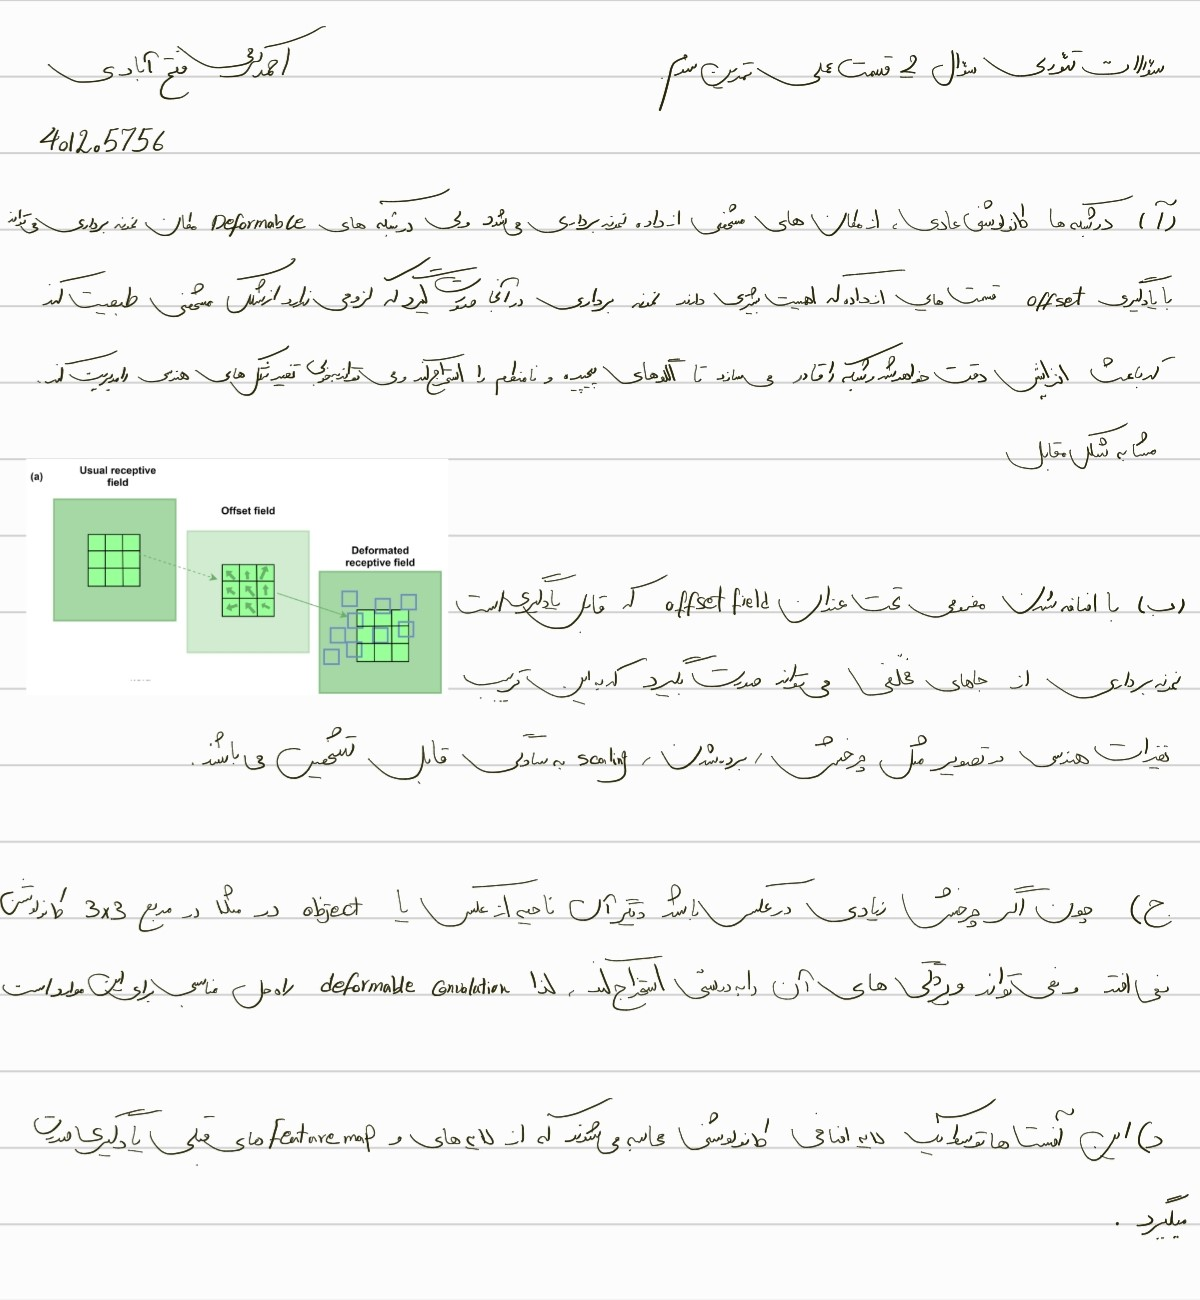

بخش عملی

In [1]:
%%capture
# download the data for training and validation and annoations and unziop them
import os
if 'val2017.zip' not in  os.listdir() :
  ! wget {'http://images.cocodataset.org/zips/val2017.zip'}
  ! wget {'http://images.cocodataset.org/zips/train2017.zip'}
  ! unzip "val2017.zip"
  ! unzip "train2017.zip"
  ! wget {'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'}
  ! unzip "annotations_trainval2017.zip"

In [2]:
from __future__ import print_function
import torch
from torch import nn
import numpy as np
import random
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision.ops
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda
import time
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import random_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
dtype=torch.float32

Using cuda device


In [3]:
# to get labels of our data define coco_train and coco_val and pass information about each one to them
coco_train = COCO('annotations/instances_train2017.json')
coco_val = COCO('annotations/instances_val2017.json')
cats = coco_train.loadCats(coco_train.getCatIds())
supercategory = list(set([cat['supercategory']  for cat in cats]))
# all supercategories which is easiar to interpret

print(f'supercategory ={(supercategory)}')

loading annotations into memory...
Done (t=19.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
supercategory =['vehicle', 'appliance', 'outdoor', 'animal', 'kitchen', 'indoor', 'sports', 'furniture', 'accessory', 'electronic', 'person', 'food']


In [4]:
# define a dictionary that each file name has an id
image_ids_dict = {img['file_name']: img['id'] for img in coco_train.dataset['images']}
# define a function that get image name and coco instance type and return a tensor with 12 entity 0,1 
def lable_maker(image_name, Coco):
  supercategory =['furniture', 'appliance', 'person', 'outdoor', 'sports', 'food', 'indoor', 'animal', 'electronic', 'vehicle', 'kitchen', 'accessory']
  cat_ids = Coco.getCatIds()
  anns_ids = Coco.getAnnIds(image_ids_dict[image_name] , catIds=cat_ids, iscrowd=None)
  anns = Coco.loadAnns(anns_ids)
  unique_supercats = set()
  for ann in anns:
      supercat  =(Coco.loadCats(ann['category_id'])[0]['supercategory'])
      unique_supercats.add(supercat)
      # assign to each image catagory 1 and others to 0
      output = torch.tensor( [1 if item in list(unique_supercats) else 0 for item in supercategory])
  return output


{'furniture', 'person', 'animal'}
['vehicle', 'appliance', 'outdoor', 'animal', 'kitchen', 'indoor', 'sports', 'furniture', 'accessory', 'electronic', 'person', 'food']
output tensor:  tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])


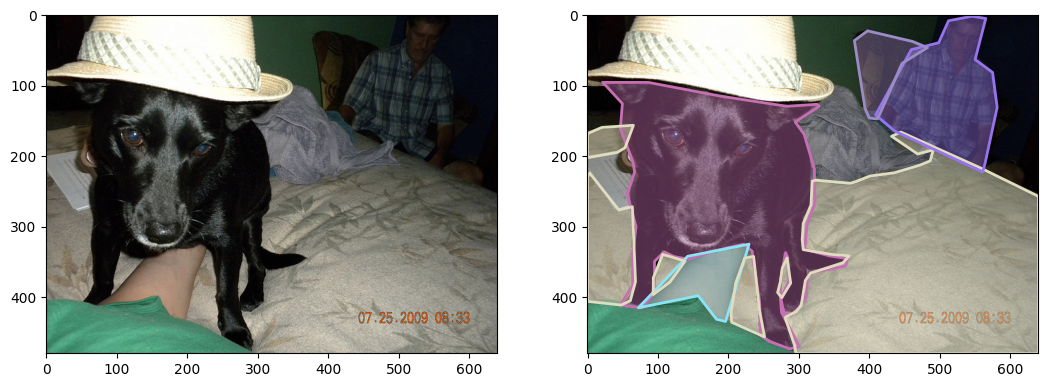

In [5]:
# show an image and apply coco object detection on it
random.seed(5)
image_name = random.choice(os.listdir('train2017'))

catIds = coco_train.getCatIds();

imgIds = coco_train.getImgIds(imgIds = image_ids_dict[image_name])
img = coco_train.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
image = np.array(Image.open(os.path.join('train2017',img['file_name'])))

_,ax = plt.subplots( 1,2 , figsize=(image.shape[1]/50, image.shape[0]/50))
ax[0].imshow(image)
ax[1].imshow(image)
annIds = coco_train.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_train.loadAnns(annIds)
coco_train.showAnns(anns)

cat_ids = coco_train.getCatIds()
anns_ids = coco_train.getAnnIds(image_ids_dict[image_name] , catIds=cat_ids, iscrowd=None)
anns = coco_train.loadAnns(anns_ids)
unique_supercats = set()
for ann in anns:
    supercat  =(coco_train.loadCats(ann['category_id'])[0]['supercategory'])
    unique_supercats.add(supercat)

print(unique_supercats)
print(supercategory)
print('output tensor: ',lable_maker(image_name, coco_train))

In [6]:
# define coco dataset
class CustomDataset(Dataset):
    def __init__(self, imgs_root ,coco, transform=None):
        # self.img_dir = img_dir
        self.transform = transform
        self.path  = imgs_root
        self.imgs_name = os.listdir(imgs_root)
        self.coco = coco

    def __len__(self):
        return len(self.imgs_name)

    def __getitem__(self, idx):
        # print(self.imgs_name[idx])
        image = cv2.imread((os.path.join(self.path,self.imgs_name[idx])))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image =  torch.from_numpy(image)/255.0

        label = lable_maker(self.imgs_name[idx], self.coco)

                
        return image.permute(2,0,1) ,label

In [7]:
# define coco dataloader for training and validation
dataset_train = CustomDataset('train2017', coco_train)
train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)

dataset_val = CustomDataset('train2017',coco_train)
val_loader = DataLoader(dataset_val, batch_size=8, shuffle=True)


In [8]:
# show image function
def show_images(num_images,train_org):
    _,axes = plt.subplots( 1,num_images , figsize=(15, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(train_org[i])
        ax.set_title(f'{i+1} image')
        ax.axis('off')

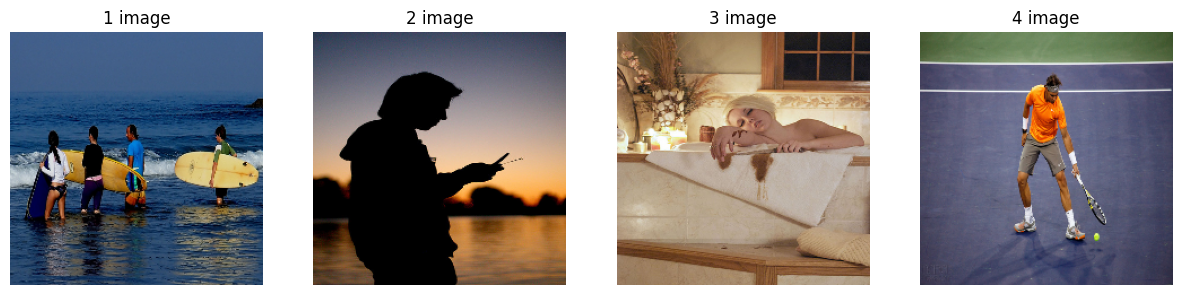

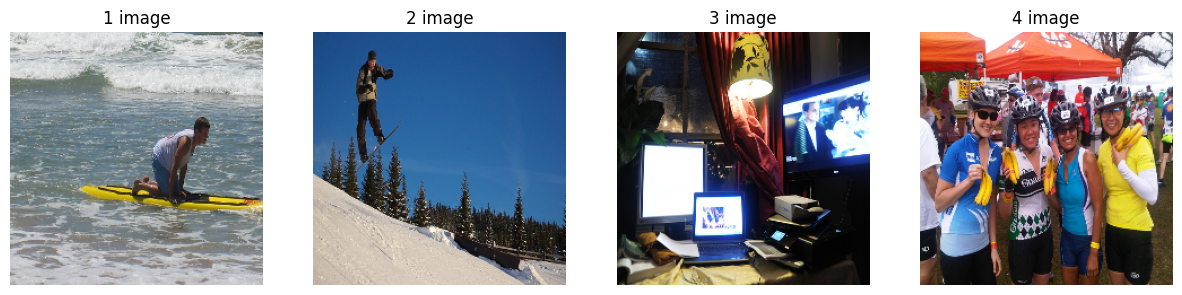

In [9]:
# show 4 pictures of trainig data
for i, data in enumerate(train_loader, 0):
    train_org , train_lab =data
    break
show_images(4,train_org.permute(0,2,3,1))

# show 4 pictures of validation data
for i, data in enumerate(val_loader, 0):
    val_org , val_lab =data
    break
show_images(4,val_org.permute(0,2,3,1))

In [ ]:
# define Deformable Conv2d 
class DeformableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,
                 stride=1, padding=1, bias=False):

        super(DeformableConv2d, self).__init__()

        self.padding = padding

        self.offset_conv = nn.Conv2d(in_channels, 2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, stride=stride,
                                     padding=self.padding, bias=True)
        # initiate offset_conv wights to 0
        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(in_channels, 1 * kernel_size * kernel_size,
                                     kernel_size=kernel_size, stride=stride,
                                     padding=self.padding, bias=True)
        # initiate modulator_conv wights to 0
        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                                      kernel_size=kernel_size,stride=stride,
                                      padding=self.padding, bias=bias)

    def forward(self, x):
        h, w = x.shape[2:]
        max_offset = max(h, w)/4.

        offset = self.offset_conv(x).clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))

        x = torchvision.ops.deform_conv2d(input=x, offset=offset,
                                          weight=self.regular_conv.weight, bias=self.regular_conv.bias,
                                          padding=self.padding,mask=modulator )
        return x

In [ ]:
import torch.nn as nn

class DCN_model(nn.Module):
    def __init__(self,
                 deformable=False):

        super(DCN_model, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        conv = nn.Conv2d if deformable==False else DeformableConv2d
        # if deformable==False all conv2ds are simple conv else DeformableConv2d
        self.conv4 = conv(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv5 = conv(32, 32, kernel_size=3, stride=1, padding=1, bias=True)

        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        # pass the input
        x = torch.relu(self.conv1(x))
        x = self.pool(x) # [14, 14]
        x = torch.relu(self.conv2(x))
        x = self.pool(x) # [7, 7]
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = self.gap(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [ ]:
# Use Mnist dataset to train the model
class MNISTDataLoader:
    def __init__(self , shuffle=True):
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])
        self.train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        self.test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        self.shuffle = shuffle

    def train_loader(self,batch_size ):
        return DataLoader(self.train_dataset, batch_size=batch_size, shuffle=self.shuffle)

    def test_loader(self,batch_size):
        return DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
data_loader = MNISTDataLoader()
train_data= data_loader.train_loader(64)
test_data= data_loader.test_loader(64)

100%|██████████| 9912422/9912422 [00:00<00:00, 77980387.06it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45989253.54it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25341196.93it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4891021.51it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# test model that calculate and return the accuracy of the model 
def test(model, loss_function, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    num_data = 0
    with torch.no_grad():
        for data, target in test_loader:
            org_data, target = data.to(device), target.to(device)

            for scale in np.arange(0.5, 1.6, 0.1): # [0.5, 0.6, ... ,1.2, 1.3, 1.4, 1.5]
                data = transforms.functional.affine(org_data, scale=scale, angle=0, translate=[0,0],shear=0)
                output = model(data)
                test_loss += loss_function(output, target).item()  # sum up batch mean loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                num_data += len(data)

    test_loss /= num_data

    test_acc = 100. * correct / num_data
    return test_acc


In [ ]:
# our main function in input is false are convs are simple if we pass true two of them become deformable
def deformable_conv(use_deformable_conv=False):
    # Training setting
    epochs=5
    model = DCN_model(use_deformable_conv).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    loss_function = nn.CrossEntropyLoss()
    best_test_acc = 0.
    for i in range(epochs):
        start_time = time.time()
        for _, (data, target) in enumerate(train_data):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
        end_training_time = time.time()
        best_test_acc = max(best_test_acc, test(model, loss_function, device, test_data))
        end_tset_time = time.time()
        scheduler.step()
        # shoe results for the last epoch
        if i == 4:
          print(f"Training time: {end_training_time - start_time} seconds")
          print(f"Test time: {end_tset_time - end_training_time} seconds")
    print(f"best accuracy with use deformable:{use_deformable_conv}: ", f"{best_test_acc:.2f}")

In [ ]:
deformable_conv(use_deformable_conv=False)

Training time: 73.839350938797 seconds
Test time: 49.9574089050293 seconds
best accuracy with use deformable:False:  87.34


In [ ]:
deformable_conv(use_deformable_conv=True)

Training time: 567.0338869094849 seconds
Test time: 163.99327421188354 seconds
best accuracy with use deformable:True:  92.06


We can see the accuracy is better in deformable but the time for training and validation are really greater too